In [17]:
# Импортируем все необходимые библиотеки
import pandahouse
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np

In [18]:
# Подключаемся к clickhouse
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220620',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [19]:
# Вытаскиваем пользователей
q = """
SELECT distinct user_id
FROM {db}.feed_actions
WHERE toDate(time) >= '2022-05-24' and toDate(time) <= '2022-05-30'
"""

users_df = pandahouse.read_clickhouse(q, connection=connection)
users_df.head()

,user_id
0,115269
1,122097
2,132354
3,134989
4,135083


In [20]:
# Делаем группы
q = """
SELECT xxHash64(toString(user_id)||'my_salt')%5 as exp_group, 
    uniqExact(user_id)
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-05-24' and toDate(time) <= '2022-05-30' 
group by exp_group 
"""

pandahouse.read_clickhouse(q, connection=connection)

,exp_group,uniqExact(user_id)
0,0,10091
1,1,9976
2,2,9966
3,3,10140
4,4,9976


In [21]:
# Смотрим на нужные нам группы (1 и 2), записываем их в датафрейм

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-05-24' and toDate(time) <= '2022-05-30' 
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


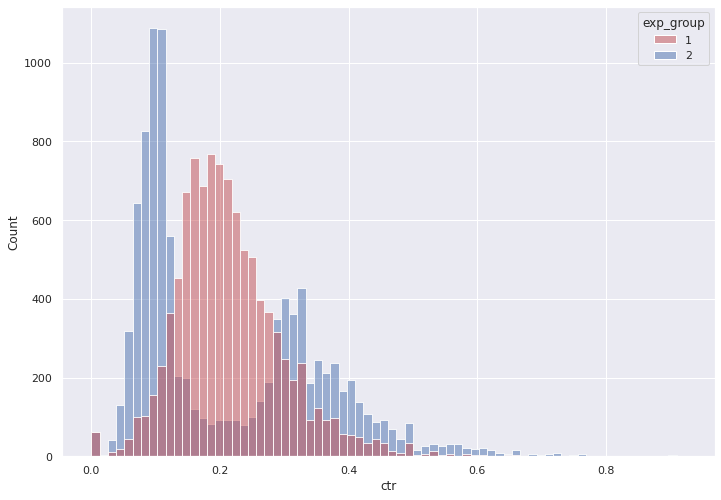

In [22]:
# Посмотрим на графики глазами
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

## На графике хорошо видно, что во 2 группе, где был использован новый алгоритм рекомендации постов, получилось бимодальное распределение CTR c 2 "пиками".
## В тестовой группе распеделение осталось одномодальным.

## Почему так произошло? Есть несколько гипотез. Первая заключается в том, что части таргет группы новый алгоритм "не зашел", а другой - "зашел", поэтому у одних CTR вырос, у других - упал. Соответственно, получилось два пика. Вторая гипотеза - у части таргет-группы что-то сломалось в новом алгоритме и он им показывал посты с "багами". Соотвественно, у части пользователей с "багами" CTR упал, у другой с работающим алгоритмом - вырос. Обе гипотезы предполагают, что новый алгоритм не устроил пользователей, в 1 случае из-за вкусовых несовпадений, во втором - из-за технических неполадок. 3 гипотеза - таргет группа изначально имела бимодальный CTR.

In [23]:
# Делаем t-тест Стьюдента
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

## P-value в тесте Стьюдента больше 0,05%. Соответственно, нулевая гипотеза о равенстве CTR в группах не отклоняется. Получается, что тест Стьюдента оказался не чувствительным к отличиям в распределении CTR. И не смотря на видимое глазами различия, статистически его не показал.

In [ ]:
# Делаем тест Манна-Уитни. Гипотетически не привязан к распределению метрики. 
print(stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr))

A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 1].ctr.sample().values[0] > df[df.exp_group == 2].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)
В 56.38 % случаев A > B. Должно получиться около 50%


## Нулевая гипотеза теста Манна-Уитни отвергается. Тест заметил различия в 2 группах, так как не привязан к распределению метрики

/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ctr'>

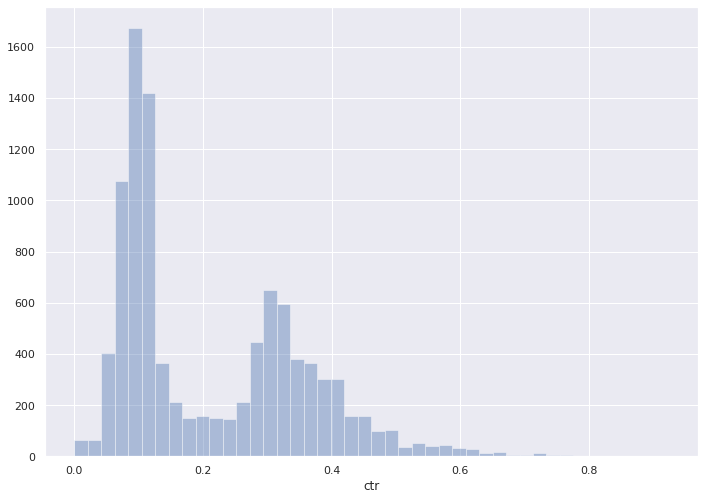

In [35]:
# Проведем тест на сглаженном ctr (α=5). Нет гарантий, что изменение сглаженного CTR будет сонаправленно изменению настоящего CTR.

def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-05-24' and toDate(time) <= '2022-05-30' 
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

group2 = df[df.exp_group == 2].copy()
sns.distplot(group2.ctr, 
             kde = False)

<AxesSubplot:xlabel='smothed_ctr'>

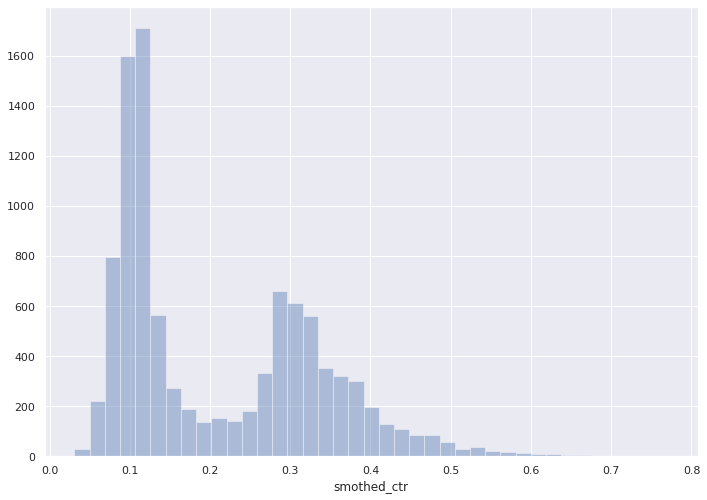

In [36]:
# Сглаженный CTR
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.distplot(group2.smothed_ctr, 
             kde = False)

In [37]:
## Проводим на сглаженном CTR тест МаннаУитни

group2 = df[df.exp_group == 2].copy()
group1 = df[df.exp_group == 1].copy()

group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

stats.ttest_ind(group2['smothed_ctr'],
                group1['smothed_ctr'],
                equal_var=False)

Ttest_indResult(statistic=-2.2841320431616983, pvalue=0.0223769815558559)

## Поверх сглаженного CTR t-тест видит отличия

In [38]:
## Проводим на сглаженном CTR тест МаннаУитни. Отличие не прокрасилось

group2 = df[df.exp_group == 2].copy()
group1 = df[df.exp_group == 1].copy()

group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

print(stats.mannwhitneyu(group2['smothed_ctr'], 
                   group1['smothed_ctr'], 
                   alternative = 'two-sided'))

A_gt_B = 0
for _ in range(10000):
    A_gt_B+= group2['smothed_ctr'].sample().values[0] > group1['smothed_ctr'].sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

MannwhitneyuResult(statistic=43381083.0, pvalue=1.6163964114270227e-61)
В 43.11 % случаев A > B. Должно получиться около 50%


## Поверх сглаженного CTR тест Манна-Уитни также видит отличия

<AxesSubplot:ylabel='Count'>

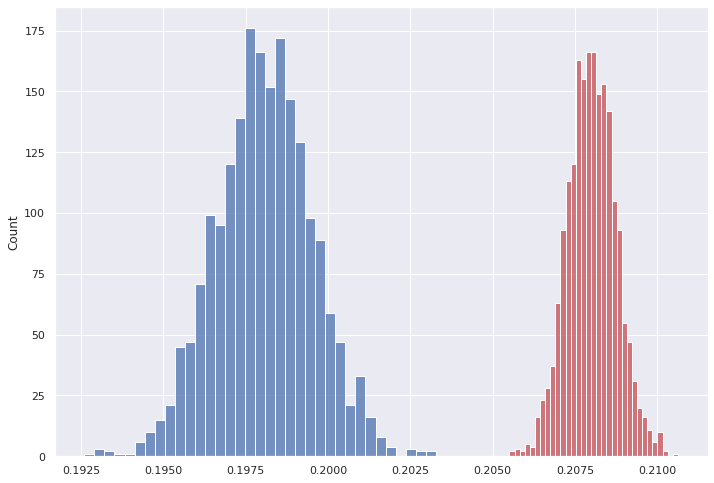

In [29]:
# Пуассоновский бутстреп - не требователен к распределению (!)

def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2


q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-05-24' and toDate(time) <= '2022-05-30' 
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""


df = pandahouse.read_clickhouse(q, connection=connection)

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1, color = ['r'])
sns.histplot(ctr2)

In [31]:
## Проведя на бутстрепе t-тест Стьюдента мы получаем pvalue равное 0 (графики не пересекаются). Соответственно, различия в CTR значимые.
stats.ttest_ind(ctr1,
                ctr2,
                equal_var=False)

Ttest_indResult(statistic=270.5961273721621, pvalue=0.0)

## Пуассоновский бутстреп показал, что в таргет группе CTR стал ниже, чем в контрольной

In [32]:
## Тест МаннаУитни поверх бакетного преобразования

q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) >= '2022-05-24' and toDate(time) <= '2022-05-30' 
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [33]:
#тест Манна-Уитни видит отличие
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

In [34]:
#и t-тест тоже
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   equal_var = False)


Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

## Поверх бакетного преобразования тест и Манна-Уитни, и t-тест видят отличие CTR

# (!) Итого: t-тест не показал отличий в CTR
# (!) Тест МаннаУитни, Пуассоновский бутстреп, а также проведенные поверх сглаженного CTR и бакетного преобразования тест МаннаУитни и t-тест показали отличия в CTR

# (!) Рекоммендация: Не раскатывать алгоритм на всех пользователей. Во-первых, потому что пуассоновский бутстреп показал, что СTR в таргет группе стал ниже, чем в контрольной группе. Во-вторых, стоит также разобраться, почему CTR стал бимодальным.